In [1]:
!pip install langgraph langchain_core langchain_groq langgraph-checkpoint-sqlite  pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langchain_groq import ChatGroq
import os
from langgraph.checkpoint.memory import MemorySaver

In [3]:
GROQ_API_KEY="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"
TAVILY_API_KEY="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"
os.environ['GROQ_API_KEY']=GROQ_API_KEY
os.environ['TAVILY_API_KEY']=TAVILY_API_KEY


In [4]:
class AgentState(TypedDict):
  task:str
  plan:str
  draft:str
  critique:str
  content: List[str]
  revision_number:int
  max_revisions:int

In [5]:
model=ChatGroq(model='llama-3.3-70b-versatile')

In [6]:
result=model.invoke('what are ai agents in 30 words?')

In [7]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [8]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [9]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [10]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [11]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [12]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
  queries:List[str]

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
!pip install tavily-python
from tavily import TavilyClient
tavily=TavilyClient()

In [14]:
def plan_node(state:AgentState):
  messages=[
      SystemMessage(content=PLAN_PROMPT),
      HumanMessage(content=state['task'])
  ]
  response=model.invoke(messages)
  return {"plan":response.content}

In [15]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [16]:
def generation_node(state:AgentState):
  content="\n\n".join(state['content'] or [])
  user_message=HumanMessage(
      content=f"{state['task']} \n\n Here is my plan: \n\n{state['plan']}]")
  messages=[
          SystemMessage(content=WRITER_PROMPT.format(content=content)),
          user_message
      ]

  response=model.invoke(messages)
  return {'draft':response.content,
          'revision_number':state.get('revision_number',1)+1}

In [17]:
def reflection_node(state:AgentState):
  messages=[
      SystemMessage(content=REFLECTION_PROMPT),
      HumanMessage(content=state['draft'])
  ]

  response=model.invoke(messages)
  return {'critique':response.content}

In [18]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [19]:
def should_continue(state):
  if state['revision_number'] > state['max_revisions']:
    return END
  return 'reflect'

In [20]:
builder=StateGraph(AgentState)

In [21]:
builder.add_node('planner',plan_node)
builder.add_node('generate',generation_node)
builder.add_node('reflect',reflection_node)
builder.add_node('research_plan',research_plan_node)
builder.add_node('research_critique',research_critique_node)

In [22]:
builder.set_entry_point('planner')

In [23]:
builder.add_conditional_edges(
    'generate',
    should_continue,
    {END:END,'reflect':'reflect'}
)

In [24]:
builder.add_edge("planner",'research_plan')
builder.add_edge('research_plan','generate')
builder.add_edge('reflect','research_critique')
builder.add_edge('research_critique','generate')

In [25]:
memory = MemorySaver()

In [26]:
graph = builder.compile(checkpointer=memory)

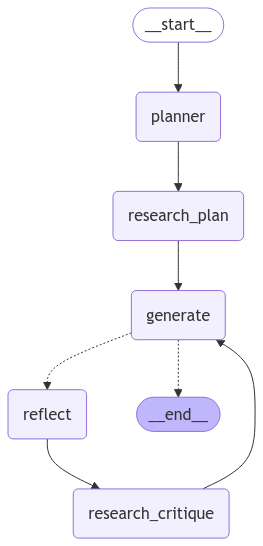

In [27]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [],  # Add content key with empty list as default
}, thread):
    print(s)

{'planner': {'plan': 'Here is a high-level outline for an essay on the difference between LangChain and Langsmith:\n\n**I. Introduction**\n* Briefly introduce LangChain and Langsmith as two AI-powered language models\n* Mention the growing interest in language models and their applications\n* Thesis statement: While both LangChain and Langsmith are language models, they have distinct differences in their architecture, capabilities, and use cases.\n\n**II. Overview of LangChain**\n* Define LangChain and its primary function (e.g., a framework for building and interacting with language models)\n* Discuss the key features of LangChain, such as its modular design and support for multiple language models\n* Provide examples of how LangChain is used in various applications (e.g., chatbots, language translation)\n\n**III. Overview of Langsmith**\n* Define Langsmith and its primary function (e.g., a language model designed for specific tasks such as text generation and editing)\n* Discuss the 

In [51]:
for item in s:
    if 'research_plan' in item:
        print(item['research_plan'])

generate
